In [1]:
%pip install --quiet --upgrade pip
%pip install --quiet --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 
%pip install \
    transformers==4.27.2 \
    datasets \
    evaluate==0.4.0 \
    rouge_score==0.1.2 \
    peft==0.3.0 --quiet
%pip install git+https://github.com/lvwerra/trl.git@25fa1bd --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.5 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.
ERROR: Ignored the following yanked versions: 0.3.0a0
ERROR: Could not find a version that satisfies the requirement torchdata==0.5.1 (from versions: 0.3.0a1, 0.3.0, 0.6.0, 0.6.1, 0.7.0, 0.7.1, 0.8.0, 0.9.0, 0.10.0, 0.10.1, 0.11.0)
ERROR: No matching distribution found for torchdata==0.5.1
Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 9.0 MB/s eta 0:00:00a 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 86.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 52.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 85.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━

In [2]:
import random
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    AutoModelForSequenceClassification,
    pipeline
)
from trl import PPOTrainer, PPOConfig, AutoModelForSeq2SeqLMWithValueHead, create_reference_model
from trl.core import LengthSampler

2025-05-24 07:19:23.920255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748071164.138429      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748071164.208022      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
dataset_original = load_dataset("majorSeaweed/toxic-dialogue-summarisation")

README.md:   0%|          | 0.00/5.27k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/76.0k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/117k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3200 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/150 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/282 [00:00<?, ? examples/s]

In [4]:
def build_dataset(model_name, dataset, min_len=200, max_len=1000):
    dataset = dataset.filter(lambda x: min_len < len(x["dialogue"]) <= max_len)
    tokenizer = AutoTokenizer.from_pretrained(model_name, device_map="auto")

    def tokenize(example):
        prompt = f"""
        Summarize the following conversation.

        {example['dialogue']}

        Summary:
        """
        toks = tokenizer.encode(prompt, return_tensors=None)
        return {"input_ids": toks, "query": tokenizer.decode(toks)}

    dataset = dataset.map(tokenize, batched=False)
    dataset.set_format(type="torch", columns=["input_ids", "query"])
    return dataset

In [5]:
model_name = "google/flan-t5-base"
dataset = build_dataset(model_name, dataset_original, min_len=200, max_len=1000)

Filter:   0%|          | 0/3200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/150 [00:00<?, ? examples/s]

Filter:   0%|          | 0/282 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Map:   0%|          | 0/2047 [00:00<?, ? examples/s]

Map:   0%|          | 0/112 [00:00<?, ? examples/s]

Map:   0%|          | 0/177 [00:00<?, ? examples/s]

In [6]:
device = torch.device('cuda')

In [7]:
test_model = AutoModelForSeq2SeqLM.from_pretrained(
    "majorSeaweed/T5-Conv_summarisation_base",
    torch_dtype=torch.bfloat16
).to(device)

config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [8]:
base_model = AutoModelForSeq2SeqLM.from_pretrained(
    "majorSeaweed/T5-Conv_summarisation_base",
    torch_dtype=torch.bfloat16
)
ppo_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(
    base_model,
    torch_dtype=torch.bfloat16,
    is_trainable=True
)
ref_model = create_reference_model(ppo_model)

In [9]:
toxicity_model_name = "facebook/roberta-hate-speech-dynabench-r4-target"
toxicity_tokenizer = AutoTokenizer.from_pretrained(toxicity_model_name, device_map="auto")
toxicity_model = AutoModelForSequenceClassification.from_pretrained(toxicity_model_name, device_map="auto")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
reward_pipe = pipeline(
    "sentiment-analysis", 
    model=toxicity_model_name,
    tokenizer=toxicity_tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    top_k=None,
    function_to_apply="none",
    batch_size=16,
    framework="pt"
)

In [11]:
not_hate_index = 0
def collator(batch):
    return {key: [d[key] for d in batch] for key in batch[0]}

In [12]:
config = PPOConfig(
    model_name=model_name,
    learning_rate=1.41e-5,
    ppo_epochs=3,
    mini_batch_size=4,
    batch_size=16
)

ppo_trainer = PPOTrainer(
    config=config,
    model=ppo_model,
    ref_model=ref_model,
    tokenizer=AutoTokenizer.from_pretrained(model_name, device_map="auto"),
    dataset=dataset["train"],
    data_collator=collator
)

In [13]:
output_sampler = LengthSampler(min_value=100, max_value=400)
generation_kwargs = {"do_sample": True, "top_k": 0, "top_p": 1.0}

In [14]:
lens = 0
for _ , i in enumerate(ppo_trainer.dataloader):
    lens += (len(i['input_ids']))

In [15]:
from itertools import cycle
from tqdm import tqdm
import torch                                   
logs = []
max_steps = 1000
dataloader = cycle(ppo_trainer.dataloader)

for step in tqdm(range(max_steps)):
    batch = next(dataloader)
    inputs = batch["input_ids"]

    responses = []
    for inp in inputs:
        gen_len = max(4, output_sampler())      
        generation_kwargs["max_new_tokens"] = gen_len
        generation_kwargs["min_new_tokens"] = 4          
        generation_kwargs["early_stopping"]  = False     
        out = ppo_trainer.generate(inp.to(device), **generation_kwargs)
        responses.append(out.squeeze())

    decoded_responses = [
        ppo_trainer.tokenizer.decode(r, skip_special_tokens=True)
        for r in responses
    ]
    queries     = batch["query"]
    full_texts  = [q + r for q, r in zip(queries, decoded_responses)]

    rewards         = reward_pipe(full_texts, batch_size=16)
    reward_vals_list = [
        torch.tensor(r[not_hate_index]["score"]).to(device) for r in rewards
    ]

    stats = ppo_trainer.step(inputs, responses, reward_vals_list)
    ppo_trainer.log_stats(stats, batch, reward_vals_list)
    logs.append({**stats, "step": step})

print("Training complete.")

  1%|          | 10/1000 [02:49<4:17:44, 15.62s/it]/usr/local/lib/python3.11/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 1000/1000 [4:33:26<00:00, 16.41s/it] 

Training complete.


In [16]:
log_df = pd.DataFrame(logs)
display(log_df.describe())
for metric in ["objective", "policy_loss", "value_loss"]:
    if metric in log_df:
        plt.figure()
        plt.plot(log_df["step"], log_df[metric])
        plt.title(metric)
        plt.xlabel("Step")
        plt.ylabel(metric)
        plt.show()

,objective/kl,objective/kl_coef,objective/entropy,ppo/mean_non_score_reward,ppo/mean_scores,ppo/std_scores,tokens/queries_len_mean,tokens/queries_len_std,tokens/responses_len_mean,tokens/responses_len_std,...,ppo/val/var,ppo/time/ppo/optimizer_step,ppo/val/var_explained,ppo/learning_rate,time/ppo/forward_pass,time/ppo/compute_rewards,time/ppo/optimize_step,time/ppo/calc_stats,time/ppo/total,step
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.668310,0.171180,35.601245,-0.003721,2.175090,1.249957,170.59725,63.191878,37.270688,12.889896,...,0.065871,0.006006,-0.209097,1.410000e-05,0.741492,0.002894,3.342760,0.005876,4.118262,499.500000
std,0.465200,0.015810,6.384997,0.003354,0.320679,0.155692,14.90169,9.781312,4.810907,3.126712,...,0.023006,0.000554,0.464367,1.084745e-19,0.090705,0.001396,0.297804,0.000559,0.386098,288.819436
min,-0.282063,0.145269,17.196507,-0.019256,1.391488,0.803115,133.25000,40.798233,24.937500,5.725673,...,0.020296,0.004599,-2.758455,1.410000e-05,0.530327,0.002393,2.546357,0.004664,3.129996,0.000000
25%,0.331954,0.157357,31.127183,-0.004971,1.927540,1.152945,160.68750,56.568504,34.046875,10.749757,...,0.052724,0.005932,-0.323740,1.410000e-05,0.642501,0.002760,3.071756,0.005693,3.748188,249.750000
50%,0.565046,0.170452,35.350029,-0.002575,2.171501,1.252767,169.25000,64.045685,37.156250,12.451819,...,0.062838,0.006042,-0.079661,1.410000e-05,0.787501,0.002850,3.412428,0.005873,4.238238,499.500000
75%,0.894987,0.184636,39.560694,-0.001414,2.418089,1.358013,180.87500,69.997496,40.687500,14.823368,...,0.079137,0.006168,0.092786,1.410000e-05,0.818091,0.002926,3.592034,0.006009,4.446006,749.250000
max,2.430822,0.200000,61.855095,0.001156,2.943159,1.691489,206.75000,89.972961,52.000000,24.535349,...,0.147863,0.017571,0.386743,1.410000e-05,0.905703,0.046378,4.071756,0.012135,5.011065,999.000000


In [22]:
test_prompts = []
sample = dataset_original["test"][10]
p = f"Summarize the following conversation.\n\n{sample['dialogue']}\n\nSummary:\n"
test_prompts.append(p)

In [23]:
results = []
for p in test_prompts:
    ids = ppo_trainer.tokenizer(p, return_tensors="pt").input_ids.to(device)

    base_out = test_model.generate(ids.to(device), max_new_tokens=200)
    base_sum = ppo_trainer.tokenizer.decode(base_out[0], skip_special_tokens=True)
    base_score = reward_pipe(base_sum)[0][not_hate_index]["score"]

    ppo_out = ppo_trainer.model.generate(ids, max_new_tokens=200)
    ppo_sum = ppo_trainer.tokenizer.decode(ppo_out[0], skip_special_tokens=True)
    ppo_score = reward_pipe(ppo_sum)[0][not_hate_index]["score"]
    results.append({
        "untuned": base_sum,
        "untuned_score": base_score,
        "tuned": ppo_sum,
        "tuned_score": ppo_score
    })

/usr/local/lib/python3.11/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [24]:
comp_df = pd.DataFrame(results)
comp_df[["untuned_score", "tuned_score"]]
print("Avg untuned score:", comp_df["untuned_score"].mean())
print("Avg tuned score:", comp_df["tuned_score"].mean())

Avg untuned score: 1.8349157571792603
Avg tuned score: 1.6162633895874023


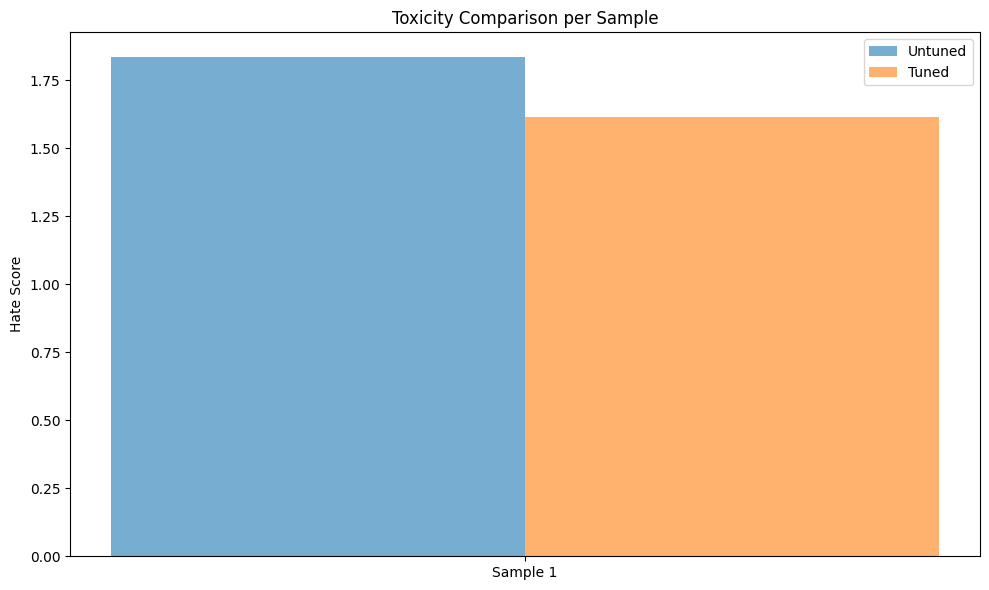

In [25]:
import matplotlib.pyplot as plt
x = np.arange(len(comp_df))  
width = 0.4  
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, comp_df["untuned_score"], width=width, alpha=0.6, label="Untuned")
plt.bar(x + width/2, comp_df["tuned_score"], width=width, alpha=0.6, label="Tuned")

plt.xticks(x, [f"Sample {i+1}" for i in x])
plt.ylabel("Hate Score")
plt.title("Toxicity Comparison per Sample")
plt.legend()
plt.tight_layout()
plt.show()

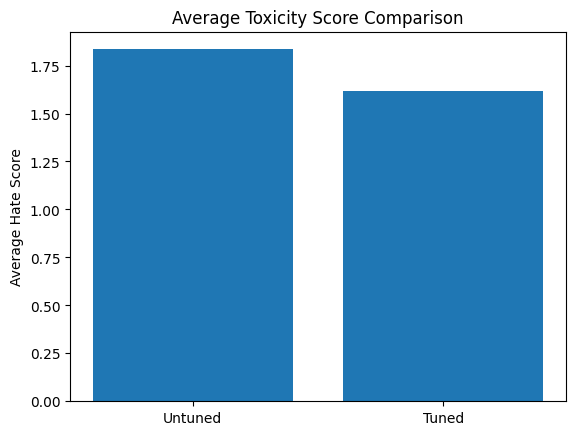

In [26]:
avg_scores = [comp_df["untuned_score"].mean(), comp_df["tuned_score"].mean()]
plt.figure()
plt.bar(["Untuned", "Tuned"], avg_scores)
plt.ylabel("Average Hate Score")
plt.title("Average Toxicity Score Comparison")
plt.show()